In [1]:
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib ipympl
plt.ioff()

The frequency of nth harmonic is given by
$$
f_n = n f_0 \sqrt{1 + Bn^2}
$$

In [2]:
def fn(n):
    return n*f0*(1+B*n**2)**0.5

$$
\begin{align*}
u(x,t) &= \sum_{n=1}^{\infty} \left( a_n \cos(2\pi f_n t) + b_n \sin(2\pi f_n t) \right) \sin\left(\frac{n\pi}{L}x\right)
\end{align*}
$$

In [60]:
def freq_to_u(a,b,x,t):
    if isinstance(x,int) or isinstance(x,float):
        # parallelize n
        u = 0
        omega_t = omega * t
        u += np.sum(a * np.cos(omega_t) * np.sin(n * np.pi * x / L), axis=0)
        u += np.sum(b * np.sin(omega_t) * np.sin(n * np.pi * x / L), axis=0)
        return u
    else:
        # parallelize both x and n
        u = 0
        omega_t = omega * t
        u += np.sum(a * np.cos(omega_t) * np.sin(n * np.pi * x[:,None] / L), axis=1)
        u += np.sum(b * np.sin(omega_t) * np.sin(n * np.pi * x[:,None] / L), axis=1)
        return u

$$
\begin{align*}
a_n(t_0^+) &= a_n(t_0^-) + \frac{2J}{L\rho\omega _n} \sin\left(\frac{n\pi}{L}x_0\right) \cos(2\pi f_n t_0) \\
b_n(t_0^+) &= b_n(t_0^-) + \frac{2J}{L\rho\omega _n} \sin\left(\frac{n\pi}{L}x_0\right) \sin(2\pi f_n t_0)
\end{align*}
$$


In [61]:
def apply_impulse(a,b,x,t,J):
    '''
    This function changes a and b in place.
    '''
    common = 2 * J / L / rho / omega * np.sin(n * np.pi * x / L)
    omega_t = omega * t
    a += common * np.cos(omega_t)
    b += common * np.sin(omega_t)

Parameters

All units are in SI

Most of the parameters can be found at *[Physical parameters for piano modeling](https://inria.hal.science/hal-00688679v1/document)*

In [85]:

# string
L = 0.4
tension = 8000 
mass = 0.013
rho = mass / L
ESK2 = 0.1 # Determins stiffness.
B = np.pi**2 * ESK2 / tension / L**2
c = (tension / rho) ** 0.5
f0 = c / (2 * L)

n_harmony = 10

# hammer

hammer_mass = 0.05
hammer_x = 0.2 * L
hammer_elasticity = 2000000

# bridge

bridge_x = 0.01 * L

# tables for faster computation
f = np.array([fn(i+1) for i in range(n_harmony)])
omega = np.array([2 * np.pi * f[i] for i in range(n_harmony)])
n = np.array([i+1 for i in range(n_harmony)])

dt = 1/44100
render_dt = 1/44100

In [80]:
# initial conditions

def init():
    global a, b, t, hammer_pos, hammer_vel
    a = np.zeros(n_harmony)
    b = np.zeros(n_harmony)
    t=0

    hammer_pos = 0.001
    hammer_vel = -5


def update():
    global t, hammer_pos, hammer_vel

    # apply impulse at x = 0.3, t = 0.3
    # if t <= 0.3 < t + dt:
    #     apply_impulse(a,b,0.3,t,0.1)

    #interact with hammer

    hammer_pos += hammer_vel * dt
    string_u = freq_to_u(a,b,hammer_x,t)
    if hammer_pos < string_u: # hammer is below the string

        # the impulse applied to the hammer
        hammer_impulse = hammer_elasticity * (string_u - hammer_pos) * dt

        # apply impulse to the hammer
        hammer_vel += hammer_impulse / hammer_mass

        # apply impulse to the string
        apply_impulse(a,b,hammer_x,t,-hammer_impulse)

    hammer_pos += hammer_vel * dt

    #apply_impulse(a,b,0.3*L,t,100*dt)

    # interact with bridge
    string_u = freq_to_u(a,b,bridge_x,t)
    apply_impulse(a,b,bridge_x,t,-string_u * 0.2)
    
    
    t += dt



Simulate and plot.

This animation code works in Notebook in VSCode. For other environments, you may need to change the code.

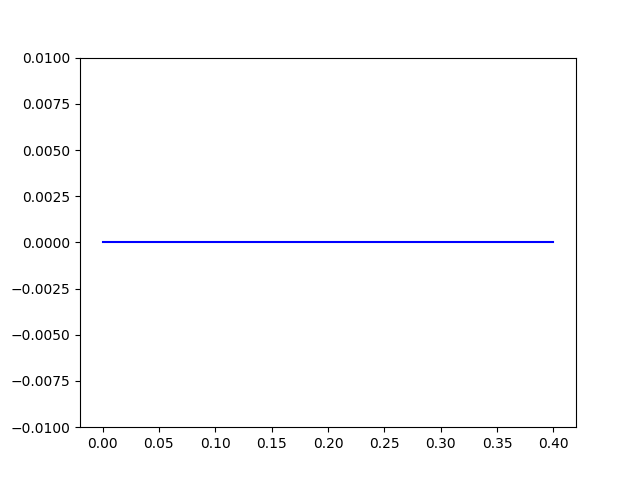

In [88]:
n_frames = 100
rendered_string = [] 
rendered_hammer_pos = []
init()
while len(rendered_string) < n_frames:
    update()
    if t//render_dt > (t-dt)//render_dt:
        rendered_string.append(freq_to_u(a,b,np.linspace(0,L,200),t))
        rendered_hammer_pos.append(hammer_pos)
        
fig, ax = plt.subplots()
ax.set_ylim(-0.01, 0.01)

line, = ax.plot(np.linspace(0,L,200),rendered_string[0], 'b')
# hammer
hammer = ax.plot([hammer_x, hammer_x], [-0, 0], 'r')[0]

def animate_step(i):
    line.set_ydata(rendered_string[i])
    hammer.set_ydata([rendered_hammer_pos[i], rendered_hammer_pos[i]+0.005])

    return line, hammer

ani = animation.FuncAnimation(fig, animate_step, frames=n_frames, interval=1000/10, repeat=False)
plt.show()

# ani.save('stiffness.mp4', writer='ffmpeg', fps=30)

Render audio.

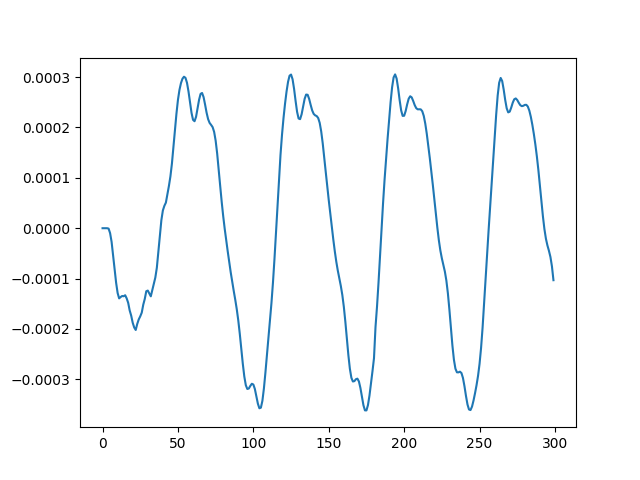

In [86]:
n_frames = 100000
rendered_string = [] 
rendered_hammer_pos = []
rendered_audio = []
init()
while len(rendered_audio) < n_frames:
    update()
    if t//render_dt > (t-dt)//render_dt:
        rendered_audio.append(freq_to_u(a,b,bridge_x,t))
plt.plot(rendered_audio[:300])
plt.show()

# save audio
import wave

audio = np.array(rendered_audio)
audio = np.clip(audio*100, -1, 1)
audio = np.int16(audio * 32767)

with wave.open('output.wav', 'wb') as wf:
    wf.setnchannels(1)
    wf.setsampwidth(2)
    wf.setframerate(44100)
    wf.writeframes(audio.tobytes())